In [1]:
%cd ..

/Users/treycole/Codes/WanPy


In [2]:
from WanPy.WanPy import *
import WanPy.models as models
import WanPy.plotting as plot

from pythtb import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sympy as sp 
import scipy
import os
cwd = os.getcwd()

In [7]:
delta = 1
t0 = 0.4
tprime = 0.5

model = models.chessboard(t0, tprime, delta).make_supercell([[2,0], [0,2]])

# adding disorder
J = 2*delta*0
J_site = 0
model.set_onsite(J, ind_i = J_site, mode='add')

orbs = model.get_orb()
n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)
lat_vecs = model.get_lat() # lattice vectors

low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)

In [8]:
model.display()

---------------------------------------
report of tight-binding model
---------------------------------------
k-space dimension           = 2
r-space dimension           = 2
number of spin components   = 1
periodic directions         = [0, 1]
number of orbitals          = 8
number of electronic states = 8
lattice vectors:
 #  0  ===>  [     2.0 ,     0.0 ]
 #  1  ===>  [     0.0 ,     2.0 ]
positions of orbitals:
 #  0  ===>  [     0.0 ,     0.0 ]
 #  1  ===>  [    0.25 ,    0.25 ]
 #  2  ===>  [     0.0 ,     0.5 ]
 #  3  ===>  [    0.25 ,    0.75 ]
 #  4  ===>  [     0.5 ,     0.0 ]
 #  5  ===>  [    0.75 ,    0.25 ]
 #  6  ===>  [     0.5 ,     0.5 ]
 #  7  ===>  [    0.75 ,    0.75 ]
site energies:
 #  0  ===>      -1.0
 #  1  ===>       1.0
 #  2  ===>      -1.0
 #  3  ===>       1.0
 #  4  ===>      -1.0
 #  5  ===>       1.0
 #  6  ===>      -1.0
 #  7  ===>       1.0
hoppings:
<  0 | H |  4 + [  0 ,  0 ] >     ===>     -0.4 +     0.0 i
<  0 | H |  2 + [  0 ,  0 ] >     ===>    

In [9]:
u_wfs_full = wf_array(model, [20, 20])
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)

print(f"Chern number: {chern:.2f}")

Chern number: -1.00


(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': "$C = -1.0$ | $\\Delta = 1,\\ t_0 = 0.4,\\ t' = 0.5$"}, ylabel='Energy $E(\\mathbf{{k}})$ '>)

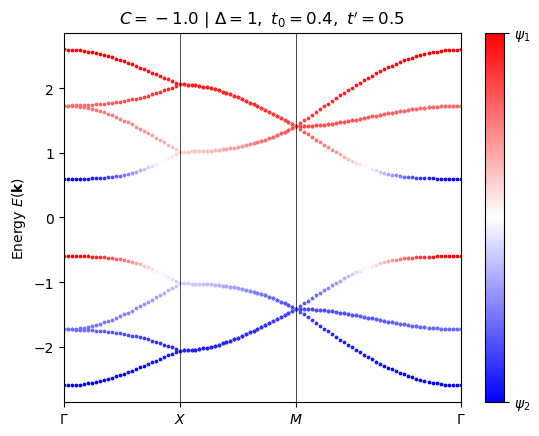

In [10]:
k_path = [[0.0, 0.0], [0.0, 0.5], [0.5, 0.5], [0.0, 0.0]]
k_label = (r'$\Gamma $',r'$X$', r'$M$', r'$\Gamma $')

title = (rf"$C = {chern: .1f}$ | $\Delta = {delta},\ t_0 = {t0},\ t' = {tprime}$")

plot.plot_bands(
    model, k_path=k_path, k_label=k_label, sub_lat=True, red_lat_idx=high_E_sites, title=title)

In [11]:
# 2D k-mesh
nkx = 20
nky = 20
Nk = nkx*nky

k_mesh = gen_k_mesh(nkx, nky, flat=False, endpoint=False)
k_mesh_flat = gen_k_mesh(nkx, nky, flat=True, endpoint=False)

u_wfs_Wan = wf_array(model, [nkx, nky])

for i in range(k_mesh.shape[0]):
    for j in range(k_mesh.shape[1]):
        u_wfs_Wan.solve_on_one_point(k_mesh[i,j], [i,j])

In [17]:
random = False

omit_sites = 2
tf_list = list(np.setdiff1d(low_E_sites, [omit_sites])) # delta on lower energy sites omitting the last site

if random:
    tf_list = gen_rand_tf_list(3, n_orb)

In [18]:
w0, psi_til_wan = Wannierize(orbs, u_wfs_Wan, tf_list, ret_psi_til=True)
u_tilde_wan = get_bloch_wfs(orbs, psi_til_wan, k_mesh, inverse=True)

In [19]:
save_name = f'C={chern:.1f}_Delta={delta}_t0={t0}_tprime={tprime}'
if J!=0:
    save_name += f'_J={J}_onsite_{J_site}'
if random:
    save_name += '_tfxs=rand'
else:
    save_name += '_tfx={tf_list}'

In [20]:
M = k_overlap_mat(lat_vecs, orbs, u_tilde_wan) # [kx, ky, b, m, n]
spread, expc_r, expc_rsq = spread_recip(lat_vecs, M, decomp=True)

print("After first projection")
print(rf"Spread = {spread[0]}")
print(rf"Omega_I = {spread[1]}")
print(rf"Omega_til = {spread[2]}")
print("Centers:\n" f"{expc_r.round(10)}")

After first projection
Spread = [0.27648419 0.29571951 0.27648419]
Omega_I = 0.7570854762869033
Omega_til = 0.09160242273614834
Centers:
[[-0. -0.]
 [ 1. -0.]
 [ 1.  1.]]


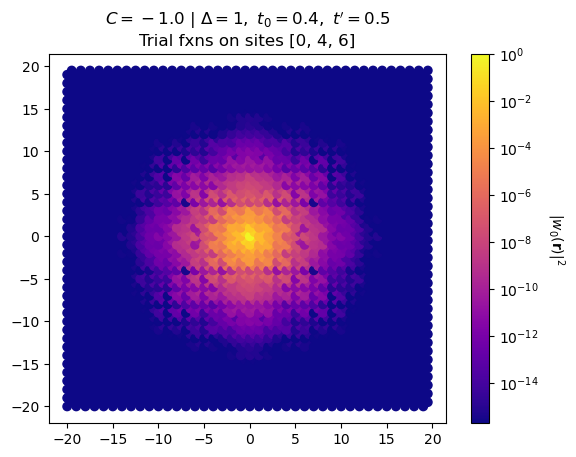

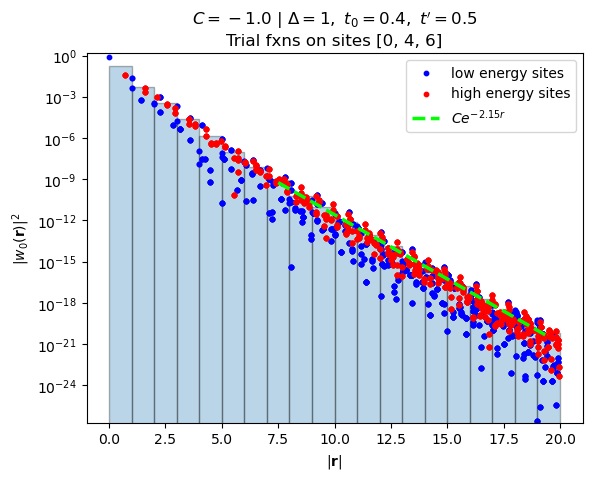

In [21]:
idx = 0
title = rf"$C = {chern: .1f}$ | $\Delta = {delta},\ t_0 = {t0},\ t' = {tprime}$"
if random:
        title += "\n" r"Trial fxns with random weights"
else:
        title +=  "\n" rf"Trial fxns on sites {tf_list}"

fig_save_name = f'w_{idx}_scatter_' + save_name + '.png'

fig, ax = plot.plot_Wan(w0, idx, orbs, lat_vecs, title=title, plot_phase=False, plot_decay=True, fit_rng=[7, 20])

In [24]:
# outer window of entangled bands is full occupied manifold
iter_num_omega_i = 100
iter_num_omega_til = 100

outer_states = u_wfs_Wan._wfs[..., :n_occ, :]
W0_save_name = save_name + f'_iter_num_omega_i={iter_num_omega_i}_iter_num_omega_til={iter_num_omega_til}.npy'
W0_max_loc, u_wf_max_loc, Wf_cntrs, spread = max_loc_Wan(lat_vecs, orbs, u_wfs_Wan, tf_list, outer_states, 
        iter_num_omega_i=iter_num_omega_i, iter_num_omega_til=iter_num_omega_til,
        Wan_idxs=None, verbose=True, return_uwfs=True, return_wf_centers=True, return_spread=True, eps=1e-3,
        save=False, save_name=W0_save_name
        )

0 Omega_I: 0.7554307531963601
1 Omega_I: 0.753858795473476
2 Omega_I: 0.7523560168532473
3 Omega_I: 0.750912521093556
4 Omega_I: 0.7495208902142901
5 Omega_I: 0.7481754257089456
6 Omega_I: 0.746871654901474
7 Omega_I: 0.7456059995938433
8 Omega_I: 0.7443755476110527
9 Omega_I: 0.7431778915558706
10 Omega_I: 0.7420110126192958
11 Omega_I: 0.7408731953033416
12 Omega_I: 0.7397629637997802
13 Omega_I: 0.7386790338298199
14 Omega_I: 0.7376202757127825
15 Omega_I: 0.7365856857177135
16 Omega_I: 0.7355743636114912
17 Omega_I: 0.7345854949015332
18 Omega_I: 0.7336183366764848
19 Omega_I: 0.732672206232288
20 Omega_I: 0.7317464718754262
21 Omega_I: 0.7308405454411803
22 Omega_I: 0.729953876173692
23 Omega_I: 0.7290859456941213
24 Omega_I: 0.7282362638438027
25 Omega_I: 0.7274043652345261
26 Omega_I: 0.7265898063733723
27 Omega_I: 0.7257921632563623
28 Omega_I: 0.7250110293459977
29 Omega_I: 0.7242460138647866
30 Omega_I: 0.7234967403491872
31 Omega_I: 0.7227628454192505
32 Omega_I: 0.722043977

In [29]:
# save_name = f'C={chern:.1f}_Delta={delta}_t0={t0}_tprime={tprime}_tfxs=rand_iter_num_omega_i={5000}_iter_num_omega_til={5000}.npy'

# sv_dir = 'data'
# if not os.path.exists(sv_dir):
#     os.makedirs(sv_dir)
# sv_prefix = 'W0_max_loc'
# np.save(f"{sv_dir}/{sv_prefix}_{save_name}", W0_max_loc)
# sv_prefix = 'W0_max_loc_cntrs'
# np.save(f"{sv_dir}/{sv_prefix}_{save_name}", Wf_cntrs)
# # sv_prefix = 'u_wfs_max_loc'
# # np.save(f"{sv_dir}/{sv_prefix}_{save_name}", Wf_cntrs)

In [25]:
Wf_cntrs.round(7)

array([[ 0., -0.],
       [ 1.,  0.],
       [ 1.,  1.]])

Center [ 0. -0.]


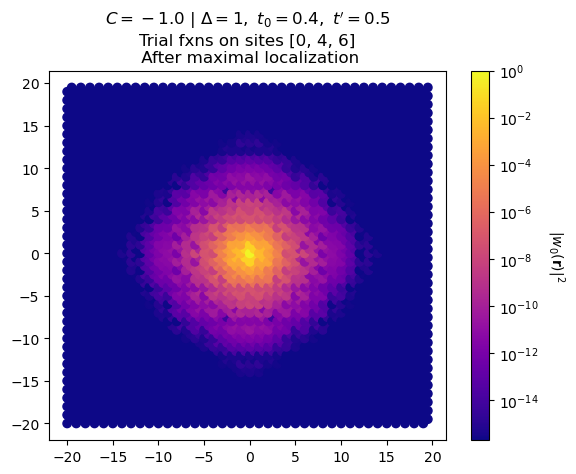

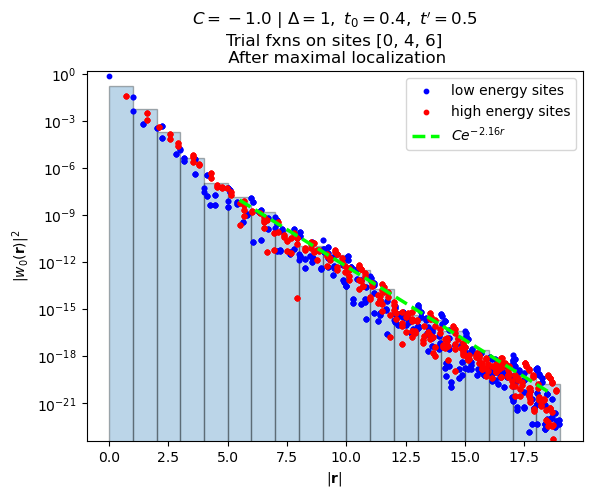

([<Figure size 640x480 with 2 Axes>, <Figure size 640x480 with 1 Axes>],
 [<Axes: title={'center': "$C = -1.0$ | $\\Delta = 1,\\ t_0 = 0.4,\\ t' = 0.5$\nTrial fxns on sites [0, 4, 6]\n After maximal localization"}>,
  <Axes: title={'center': "$C = -1.0$ | $\\Delta = 1,\\ t_0 = 0.4,\\ t' = 0.5$\nTrial fxns on sites [0, 4, 6]\n After maximal localization"}, xlabel='$|\\mathbf{r}|$', ylabel='$|w_0(\\mathbf{r})|^2$'>])

In [27]:
title += "\n After maximal localization"
Wan_idx = 0
print(f"Center {Wf_cntrs[Wan_idx].round(7)}")
plot.plot_Wan(W0_max_loc, Wan_idx, orbs, lat_vecs, title=title, plot_decay=True, show=True)